# WhatsApp Chat Analysis

This notebook reads exported WhatsApp chat data and performs some basic analysis on it.

In [125]:
from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import STOPWORDS, WordCloud

from scripts.chat_analyser import *

## 1. Extracting the data from the WhatsApp chat

In [126]:
conversation = '../data/WhatsApp Chat with .txt'
data = extract_data(conversation)

In [127]:
# Getting basic details of the chat
df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])
print(df.tail())
print(df.info())
print(df.Author.unique())

           Date     Time         Author                              Message
6121 2022-04-26  9:55 am     Anmol Soni                                  Ohh
6122 2022-04-26  9:55 am     Anmol Soni  I have a meeting with my supervisor
6123 2022-04-26  9:55 am  Lekha Nambiar                              Oh okay
6124 2022-04-26  9:56 am  Lekha Nambiar                    I don't this week
6125 2022-04-26  9:56 am  Lekha Nambiar                                    😛
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6126 entries, 0 to 6125
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     6126 non-null   datetime64[ns]
 1   Time     6126 non-null   object        
 2   Author   5886 non-null   object        
 3   Message  6126 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 191.6+ KB
None
['Lekha Nambiar' 'Anmol Soni' None 'Lekha Nambiar:']


In [128]:
Authors = df.Author.unique()[:2]
df = df[df.Author.isin(Authors)]

In [129]:
# Total messages in the chat
total_messages = df.shape[0]
# Total media in the chat
media_messages = df[df["Message"] == '<Media omitted>'].shape[0]
# Count emojis
df['emoji'] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
# Count URLs
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [130]:
# Print general statistics of the chat
print(f"Chats between {Authors}")
print("Total Messages: ", total_messages)
print("Number of Media Shared: ", media_messages)
print("Number of Emojis Shared", emojis)
print("Number of Links Shared", links)

Chats between ['Lekha Nambiar' 'Anmol Soni']
Total Messages:  5881
Number of Media Shared:  178
Number of Emojis Shared 1186
Number of Links Shared 7


In [131]:
# Get chat statistics
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s: len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s: len(s.split(' ')))
messages_df["MessageCount"] = 1

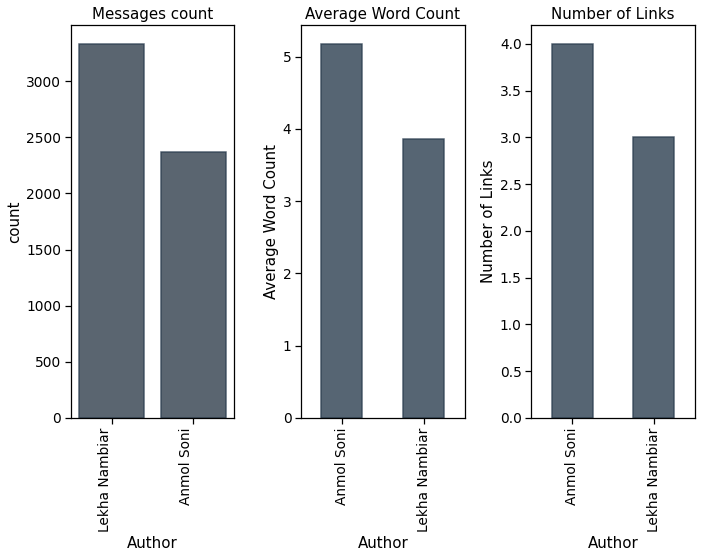

In [132]:
# Most active person in the chat
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
sns.countplot(x='Author', data=messages_df, ax=axs[0]
              , edgecolor='#2c3e50', linewidth=1.5, color='#2c3e50', alpha=0.8, )
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, ha="right")
axs[0].set_title('Messages count')

messages_df.groupby(['Author'])['Word_Count'].mean().plot(kind='bar', ax=axs[1], color='#2c3e50',
                                                          edgecolor='#2c3e50', linewidth=1.5, alpha=0.8, )
axs[1].set_ylabel('Average Word Count')
axs[1].set_title('Average Word Count')

messages_df.groupby(['Author'])['urlcount'].sum().plot(kind='bar', ax=axs[2], color='#2c3e50',
                                                            edgecolor='#2c3e50', linewidth=1.5, alpha=0.8, )
axs[2].set_ylabel('Number of Links')
axs[2].set_title('Number of Links')
plt.tight_layout()
plt.show()


In [133]:
# Most used emoji in the chat
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)

total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])

fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text='Most used emojis')
fig.show()

In [134]:
for author in Authors:
    author_df = df[df['Author'] == author]
    # Most used emoji in the chat
    total_emojis_list = list(set([a for b in author_df.emoji for a in b]))
    total_emojis = len(total_emojis_list)

    total_emojis_list = list([a for b in author_df.emoji for a in b])
    emoji_dict = dict(Counter(total_emojis_list))
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

    emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])

    fig = px.pie(emoji_df, values='count', names='emoji')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update_layout(title_text='Most used emojis by ' + author)
    fig.show()

There are 125434 words in all the messages.


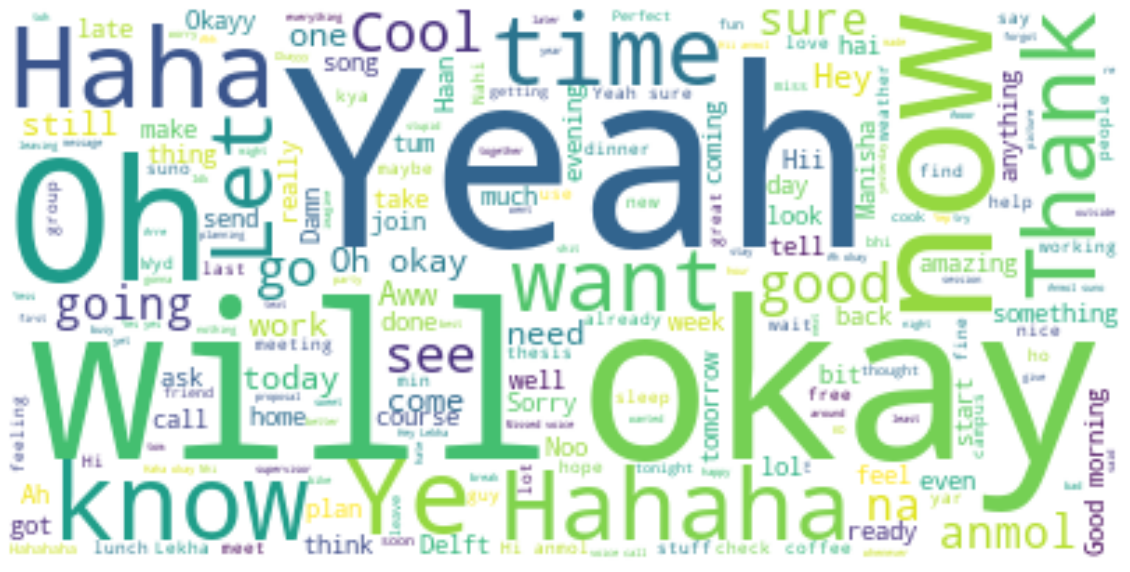

In [135]:
# Most used words in the chat
sns.set_context("notebook", font_scale=1.25)
text = " ".join(review for review in messages_df.Message)
print("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author name Lekha Nambiar


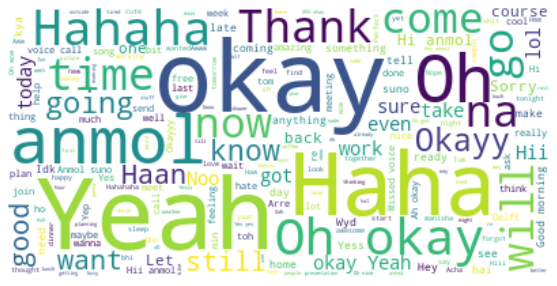

Author name Anmol Soni


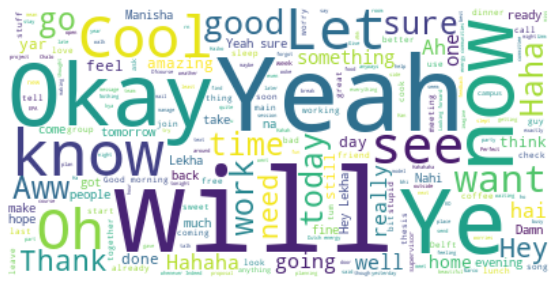

In [136]:
# Most used words by individual users
l = Authors
for i in range(len(l)):
    dummy_df = messages_df[messages_df['Author'] == l[i]]
    text = " ".join(review for review in dummy_df.Message)
    stopwords = set(STOPWORDS)
    #Generate a word cloud image
    print('Author name', l[i])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    #Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [137]:
# Create a 'Day' column
messages_df['Date'] = pd.to_datetime(messages_df['Date'])
weeks = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
messages_df['Day'] = messages_df['Date'].dt.weekday.map(weeks)

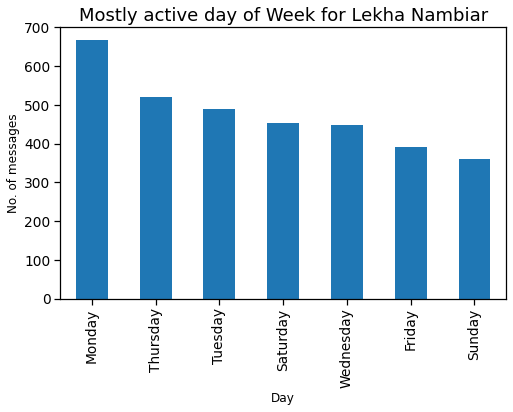

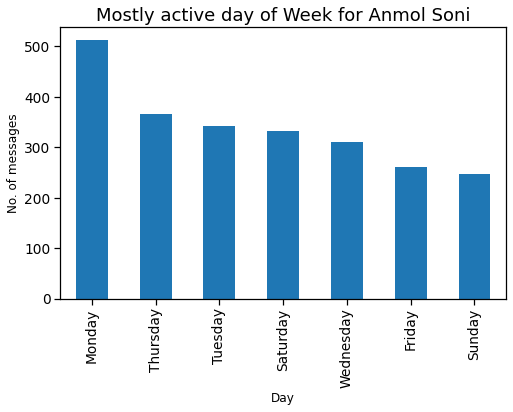

In [138]:
### Mostly Active day in the Group
for author in Authors:
    plt.figure(figsize=(8, 5))
    active_day = messages_df[messages_df['Author'] == author]['Day'].value_counts()
    ### Top 10 peoples that are mostly active in our Group is :
    a_d = active_day.head(10)
    a_d.plot.bar()
    plt.xlabel('Day', fontdict={'fontsize': 12, 'fontweight': 10})
    plt.ylabel('No. of messages', fontdict={'fontsize': 12, 'fontweight': 10})
    plt.title(f'Mostly active day of Week for {author}', fontdict={'fontsize': 18, 'fontweight': 8})
    plt.show()

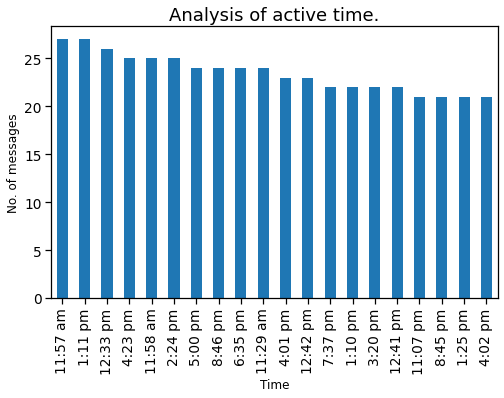

In [139]:
### Time whenever our group is highly active
plt.figure(figsize=(8, 5))
t = messages_df['Time'].value_counts().head(20)
tx = t.plot.bar()
# tx.yaxis.set_major_locator(MaxNLocator(integer=True))  #Converting y axis data to integer
plt.xlabel('Time', fontdict={'fontsize': 12, 'fontweight': 10})
plt.ylabel('No. of messages', fontdict={'fontsize': 12, 'fontweight': 10})
plt.title('Analysis of active time.', fontdict={'fontsize': 18, 'fontweight': 8})
plt.show()